In [1]:
import matplotlib.pyplot as plt

import uxarray as ux

uxds = ux.open_dataset("outCSne30.ug", "outCSne30_vortex.nc")

# The imports below are used to visualize range rings in this notebook and
# are not needed for routine use of azimuthal_mean().
import math
import operator
from functools import reduce

import cartopy.geodesic as gdyn
import holoviews as hv
import numpy as np

### A helper function to draw range rings and visualize azimuthal averaging:

In [2]:
def hv_range_ring(lon, lat, rad_gcd, n_samples=2000, color="red", line_width=1):
    geo = gdyn.Geodesic()
    circ_pts = geo.circle(
        lon=lon, lat=lat, radius=rad_gcd * 111320, n_samples=n_samples
    )
    return hv.Path(circ_pts).opts(color=color, line_width=line_width)

# Azimuthal mean basics
An azimuthal average (or azimuthal mean) is a statistical measure that represents the average of a face-centered variable along rings/bands of constant distance from a specified central point. Azimuthal averaging is useful for describing circular/cylindrical features, where fields that strongly depend on distance from a center.

In UXarray, azimuthal averaging is non-conservative. This means that faces are assigned to radial bins (i.e., distance intervals from the central point) based only on the face center coordinate.

# 1. Azimuthally averaging an idealized 2D field

## Step 1.1: Visualize the global field
The global field is shaded below using the UxDataArray.plot() accessor. To help visualize azimuthal averaging, the chosen central point is marked with an 'x' and rings are drawn at every 10 great-circle degrees from the central point (37°N, 1°E).

In [11]:
# Display the global field
glob_plt = uxds["psi"].plot(
    cmap="inferno", periodic_elements="split", title="Global Field", dynamic=True
)

# Mark a center coordinate and draw range rings
lon, lat = 1, 37
glob_plt = glob_plt * hv.Points([(lon, lat)]).opts(
    color="lime", marker="x", size=10, line_width=2
)
glob_plt = glob_plt * reduce(
    operator.mul,
    [hv_range_ring(lon, lat, rr, color="lime") for rr in np.arange(10, 41, 10)],
)
glob_plt

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [x,y]   (x_y psi)
      .Points.I :Points   [x,y]
      .Path.I   :Path   [x,y]
      .Path.II  :Path   [x,y]
      .Path.III :Path   [x,y]
      .Path.IV  :Path   [x,y]

## Step 1.2: Compute the azimuthal mean
Calling `.azimuthal_mean()` with the arguments below samples every 2° out to 40 great-circle degrees around the central point.

In [4]:
azim_mean_psi, hits = uxds["psi"].azimuthal_mean(
    (lon, lat), 40.0, 2, return_hit_counts=True
)
azim_mean_psi

<xarray.DataArray 'psi_azimuthal_mean' (radius: 21)> Size: 168B
array([       nan, 0.98400088, 0.98263337, 0.98076282, 1.03482251,
       1.03210027, 0.96639787, 0.94121837, 0.99013955, 1.08111055,
       1.08413299, 0.99805499, 0.94448357, 0.90755765, 0.92506048,
       0.94187134, 0.93900079, 0.9867494 , 1.00598615, 0.98697273,
       0.99283143])
Coordinates:
  * radius   (radius) float64 168B 0.0 2.0 4.0 6.0 8.0 ... 34.0 36.0 38.0 40.0
Attributes:
    azimuthal_mean:  True
    center_lon:      1.0
    center_lat:      37.0
    radius_units:    degrees

# Step 1.3: Plot the azimuthal mean
In the plot below, red dots mark where samples were taken at 2° intervals. The green vertical lines correspond to the green rings in the global field plot.

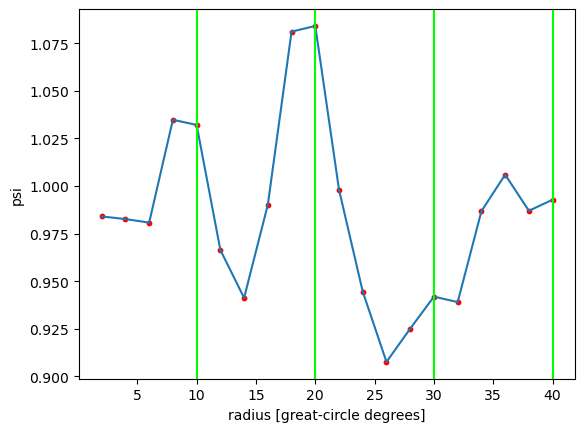

In [5]:
plt.plot(azim_mean_psi["radius"], azim_mean_psi)
plt.scatter(azim_mean_psi["radius"], azim_mean_psi, s=10, color="red")
plt.xlabel("radius [great-circle degrees]")
plt.ylabel("psi")

[plt.axvline(rr, color="lime") for rr in np.arange(10, 41, 10)]

## Step 1.4: Inspect the hit count
The plot below shows the number of face centers that fall within each distance bin. As one would expect on a near-uniformly spaced mesh, the hit count increases linearly with distance.

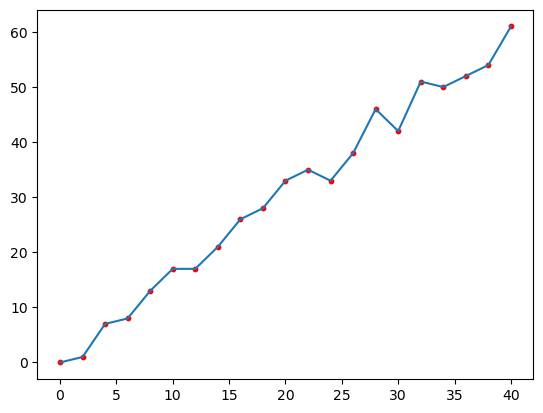

In [6]:
plt.plot(azim_mean_psi["radius"], hits)
plt.scatter(azim_mean_psi["radius"], hits, s=10, color="red")

# 2: Azimuthally averaging tropical cyclone fields
A high-resolution (~0.25°) aquaplanet general circulation model permits the development of a handful of strong tropical cyclones (TCs). Because TCs are fairly axisymmetric, azimuthal averaging is useful for transforming their fields into cylindrical coordinates and visualizing features such as their low central pressure and warm core.

In [7]:
clon, clat = 114.54, -17.66
tcds = ux.open_dataset(
    "/glade/work/jpan/uxazim_demo/ne120np4_pentagons_100310.nc",
    "/glade/work/jpan/uxazim_demo/cam.h1i.plev.0013-01-13-00000.nc",
).squeeze()

## Step 2.1: Visualize the raw surface pressure field
Because we are only interested in a single tropical cyclone, we can subset a region of the global field using a bounding circle to speed up plotting.

In [8]:
# Use a bounding circle to select faces whose centers lie
# within 5 great-circle degrees of the central point.
tcps = tcds["PS"].subset.bounding_circle((clon, clat), 5)

# Setting dynamic=True allows for quick, adaptive rendering as you zoom/pan.
# It also preserves the original mesh faces in the plot.
ps_plt = tcps.plot(
    cmap="inferno", periodic_elements="split", title="Surface pressure", dynamic=True
)
ps_plt

:DynamicMap   []
   :Image   [x,y]   (x_y PS)

## Step 2.2: Compute the azimuthal mean of the 3D fields

In [9]:
args = ((clon, clat), 3, 0.25)
azim_mean_T = tcds["T"].azimuthal_mean(*args)
azim_mean_Z = tcds["Z3"].azimuthal_mean(*args)
azim_mean_T

<xarray.DataArray 'T_azimuthal_mean' (plev: 26, radius: 13)> Size: 3kB
array([[         nan, 238.20061042, 238.07972252, 237.99570753,
        238.00888973, 238.00242869, 238.1790747 , 238.06354964,
        238.2623691 , 238.29081298, 238.16468042, 237.98864513,
        237.93356308],
       [         nan, 230.71426473, 230.68629394, 230.48409658,
        230.17606295, 230.1548325 , 229.99708408, 230.07275435,
        229.9634382 , 229.86362381, 229.91860611, 230.02733733,
        230.09972681],
       [         nan, 222.56816843, 222.71253698, 223.24577647,
        224.11031543, 224.13290827, 224.25662631, 224.28844902,
        224.29394859, 224.28484642, 224.29108044, 224.15351119,
        224.08923615],
       [         nan, 224.70788309, 224.12459941, 223.11910753,
        222.09043359, 221.93427246, 221.81130697, 221.55553468,
        221.58022862, 221.64720125, 221.55126155, 221.57687556,
        221.57393756],
       [         nan, 214.80296312, 215.94675235, 217.33697796,
        217.75477968, 218.01371142, 218.15083474, 218.22523588,
        218.26814579, 218.07331526, 218.16901897, 218.3195764 ,
        218.44510226],
...
       [         nan, 298.69938565, 297.14635909, 296.09023807,
        294.6287262 , 294.98888238, 294.97965803, 294.66028762,
        294.4298146 , 294.29170194, 294.0728373 , 293.91746256,
        293.87926481],
       [         nan, 301.02056956, 300.06934219, 299.02027043,
        298.04171151, 298.12230926, 298.04818677, 298.00621268,
        297.90135895, 297.77418827, 297.51214646, 297.38709478,
        297.35003062],
       [         nan, 303.26382152, 302.76179889, 301.71459978,
        301.0084972 , 300.73922974, 300.59966824, 300.5536293 ,
        300.48913686, 300.43193225, 300.33191518, 300.31275195,
        300.24766478],
       [         nan, 305.74284086, 305.2285953 , 304.63768279,
        304.1671658 , 303.89796862, 303.63844544, 303.53381664,
        303.46108039, 303.32145989, 303.15805181, 303.09259189,
        302.90319175],
       [         nan, 307.17291831, 306.62870387, 306.0598156 ,
        305.72815285, 305.61836845, 305.4418119 , 305.36210933,
        305.27861025, 305.11168971, 304.93262769, 304.86391603,
        304.63545043]])
Coordinates:
  * radius   (radius) float64 104B 0.0 0.25 0.5 0.75 1.0 ... 2.25 2.5 2.75 3.0
Dimensions without coordinates: plev
Attributes:
    azimuthal_mean:  True
    center_lon:      114.54
    center_lat:      -17.66
    radius_units:    degrees

# Step 2.3: Plot the TC radial profile
The contour plot below shows the warm core and low pressure of the TC. After taking the azimuthal average, we subtract the value at the outermost radius to obtain an approximate anomaly relative to the ambient environment.

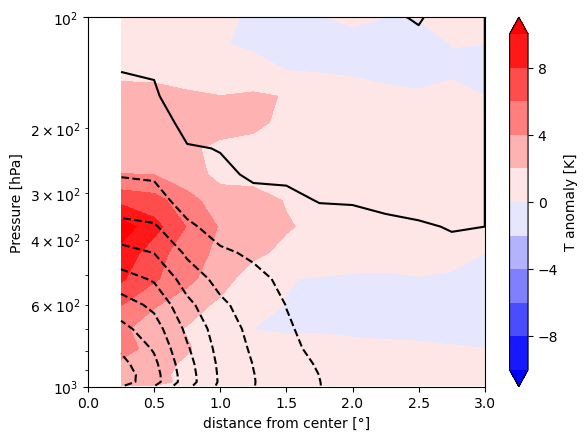

In [10]:
# Subtract the value at the outer radius
Tpert = azim_mean_T - azim_mean_T.isel(radius=-1)
Zpert = azim_mean_Z - azim_mean_Z.isel(radius=-1)

plt.contour(
    azim_mean_Z["radius"],
    tcds["plev"] / 100,
    Zpert,
    levels=np.arange(-500, 501, 50),
    colors="black",
)
plt.contourf(
    azim_mean_T["radius"],
    tcds["plev"] / 100,
    Tpert,
    levels=np.arange(-10, 11, 2),
    cmap="bwr",
    extend="both",
)
plt.xlabel("distance from center [°]")
plt.ylim(1000, 100)
plt.yscale("log")
plt.ylabel("Pressure [hPa]")
plt.colorbar(label="T anomaly [K]")